In [3]:
import textwrap, re
import numpy as np
import pandas as pd
import google.generativeai as palm
from langchain.embeddings import VertexAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
import langchain.schema

import pgvector
import psycopg2
from psycopg2.extras import execute_values
from pgvector.psycopg2 import register_vector

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from typing import List, Callable, Union


In [4]:
def embed_fn(text:str, model:str = 'models/embedding-gecko-001') -> List[float]:
  """Takes a character string and returns a list of 768 floats
  This is the vector embedding size 768

  Args:
      text (str): string of text
      model (str, optional) Name of the model you want to use. Defaults to 'models/embedding-gecko-001'

  Returns:
      List[float]: vector embeding for text string
  """
  return palm.generate_embeddings(model=model, text=text)['embedding']

In [5]:
def split_text(text: Union[str,list], 
               chunk_size:int = 100, 
               chunk_overlap: int = 20, 
               length_function: Callable[[str], int] = len, 
               **kwargs) -> List[langchain.schema.document.Document]:
    """
    Generates chunks of text with specified size and overlap.

    Args:
        text (Union[str,list]): Maximum size of chunks to return. The funtion attempts to keep sentences together the best it can.
        chunk_size (int, optional): Overlap in characters between chunks. Defaults to 100.
        chunk_overlap (int, optional): Function that measures the length of given chunks. Defaults to 20.
        length_function (Callable[[str], int], optional): Function that measures the length of given chunks. Defaults to len.
        kwargs:  https://api.python.langchain.com/en/latest/_modules/langchain/text_splitter.html#TextSplitter

    Returns:
        List[langchain.schema.document.Document]: List of langchain document chunks
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = chunk_size,
        chunk_overlap  = chunk_overlap,
        length_function = length_function, **kwargs
    )
    #Split the long unstructured string
    if isinstance(text, str):
        text = [text]
    chunks = text_splitter.create_documents(text)

    return chunks

In [6]:
def find_top_n(query: str, 
               df: pd.DataFrame, 
               text_col: str,  
               embed_col_name: str = 'embeddings', 
               n: int = 5,
               model:str = 'models/embedding-gecko-001') ->pd.DataFrame:
    """
    Compute the distances between the query and each document in the dataframe
    using the dot product.

    Args:
        query (str): query string
        dataframe (pd.DataFrame): Dataframe for your query
        text_col (str): Name of the text column in your dataframe.
        embed_col_name (str, optional): Name of the column in your dataframe that has the vector embeddings. Defaults to 'embeddings'.
        n (int, optional): Number of observations you want to return. Defaults to 5.
        model (str, optional) Name of the model you want to use. Defaults to 'models/embedding-gecko-001'


    Returns:
        pd.DataFrame: _description_
    """
    query_embedding = palm.generate_embeddings(model=model, text=query)
    dot_products = np.dot(np.stack(df[embed_col_name]), query_embedding['embedding'])

    score_df = pd.DataFrame(dot_products).sort_values(0, ascending=False)
    top_n = score_df[:n].index
    score = []
    text = []
    for idx in top_n:
        score.append(score_df.loc[idx][0])
        text.append(df.iloc[idx][text_col])

    return pd.DataFrame({'score':score,'text':text})

In [7]:
def score_passages(query:str, 
                   df:pd.DataFrame, 
                   embed_col_name: str = 'embeddings',
                   model:str = 'models/embedding-gecko-001'):
  """
  Compute the distances between the query and each document in the dataframe
  using the dot product.
  
  Args:
      query (str): query string
      dataframe (pd.DataFrame): Dataframe for your query
      embed_col_name (str, optional): Name of the column in your dataframe that has the vector embeddings. Defaults to 'embeddings'.
      model (str, optional) Name of the model you want to use. Defaults to 'models/embedding-gecko-001'

  Returns:
      _type_: _description_
  """
  query_embedding = palm.generate_embeddings(model=model, text=query)
  dot_products = np.dot(np.stack(df[embed_col_name]), query_embedding['embedding'])

  return dot_products

In [8]:
def make_prompt(leading_text:str, query:str, relevant_passage:Union[List[str],str]) -> str:
  """_summary_

  Args:
      leading_text (str): _description_
      query (str): _description_
      relevant_passage (Union[List[str],str]): _description_

  Returns:
      str: _description_
  """
  if isinstance(relevant_passage,list):
      relevant_passage = " ".join(relevant_passage)
  escaped = relevant_passage.replace("'", "").replace('"', "").replace("\n", " ")    
  prompt = textwrap.dedent("""
  '{leading_text}'
  QUESTION: '{query}'
  PASSAGE: '{relevant_passage}'

    ANSWER:
  """).format(leading_text=leading_text, query=query, relevant_passage=escaped)

  return prompt

In [9]:
with open('../.api_key', 'r') as file:
    api_key = file.readline()
# model = "models/embedding-gecko-001"
palm.configure(api_key=api_key)

In [10]:
DOCUMENT1 = "Operating the Climate Control System  Your Googlecar has a climate control system that allows you to adjust the temperature and airflow in the car. To operate the climate control system, use the buttons and knobs located on the center console. Temperature: The temperature knob controls the temperature inside the car. Turn the knob clockwise to increase the temperature or counterclockwise to decrease the temperature. Airflow: The airflow knob controls the amount of airflow inside the car. Turn the knob clockwise to increase the airflow or counterclockwise to decrease the airflow. Fan speed: The fan speed knob controls the speed of the fan. Turn the knob clockwise to increase the fan speed or counterclockwise to decrease the fan speed. Mode: The mode button allows you to select the desired mode. The available modes are: Auto: The car will automatically adjust the temperature and airflow to maintain a comfortable level. Cool: The car will blow cool air into the car. Rebecca Dolan has a red car. Heat: The car will blow warm air into the car. Defrost: The car will blow warm air onto the windshield to defrost it."
DOCUMENT2 = "Your Googlecar has a large touchscreen display that provides access to a variety of features, including navigation, entertainment, and climate control. To use the touchscreen display, simply touch the desired icon.  For example, you can touch the \"Navigation\" icon to get directions to your destination or touch the \"Music\" icon to play your favorite songs."
DOCUMENT3 = "Shifting Gears  Your Googlecar has an automatic transmission. To shift gears, simply move the shift lever to the desired position.  Park: This position is used when you are parked. The wheels are locked and the car cannot move. Reverse: This position is used to back up. Neutral: This position is used when you are stopped at a light or in traffic. The car is not in gear and will not move unless you press the gas pedal. Drive: This position is used to drive forward. Low: This position is used for driving in snow or other slippery conditions."

documents = [DOCUMENT1, DOCUMENT2, DOCUMENT3]

## Take each document and split and add to a dict

```
{'<document_1>': [<chunk_1>,<chunk_2>,...<chunk_n>],
'<document_2>': [<chunk_1>,<chunk_2>,...<chunk_n>]...
'<document_m>': [<chunk_1>,<chunk_2>,...<chunk_n>]}
```

In [11]:
documents_dict = {}
document_names = ['document_1','document_2','document_3']
for document in zip(documents,document_names):
    chunks = split_text([document[0]])
    chunk_list = []
    for c in chunks:
        chunk_list.append(c.page_content)
    documents_dict[document[1]] = chunk_list

## Turn above dict into a dataframe and then vectorize the data

In [12]:
vector_data = []
for document, texts in documents_dict.items():
    for index, text in enumerate(texts):
        vector_data.append([document, index, text])

vector_df = pd.DataFrame(vector_data, columns=['document', 'index', 'text'])

In [13]:
vector_df['embeddings'] = vector_df['text'].apply(embed_fn)
vector_df.head()

,document,index,text,embeddings
0,document_1,0,Operating the Climate Control System Your Goo...,"[-0.004682993, 0.0658743, 0.034553137, 0.04838..."
1,document_1,1,that allows you to adjust the temperature and ...,"[0.0059845652, 0.066699535, 0.0024247267, 0.05..."
2,document_1,2,"the climate control system, use the buttons an...","[0.020519787, 0.051637597, -0.015418134, 0.062..."
3,document_1,3,Temperature: The temperature knob controls the...,"[0.02814844, 0.04172512, 0.0101980055, 0.04945..."
4,document_1,4,the knob clockwise to increase the temperature...,"[0.008129629, 0.027632985, 0.0049550766, 0.039..."


## Generate query to find important chunks

This is accomplished through a series of dot products between your embedded query and the embedded chunks. They are ranked ordered and the top five are returned

In [18]:
query = "what car does Rebecca drive"

In [19]:
passage = find_top_n(query=query, df = vector_df,text_col='text',n=5)
passage

,score,text
0,0.742016,blow cool air into the car. Rebecca Dolan has ...
1,0.606225,Your Googlecar has a large touchscreen display...
2,0.587258,warm air into the car. Defrost: The car will b...
3,0.582470,Operating the Climate Control System Your Goo...
4,0.574612,you are parked. The wheels are locked and the ...


## Generate question to get back a response

* This is based on your top n chunks from above

* Your top five chunks are made into one string. There will be redundant sections based on overlap

In [20]:
leading_text = 'You are a helpful and informative bot that answers questions using text from the reference passage included below. Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. However, you are talking to a non-technical audience, so be sure to break down complicated concepts and strike a friendly and converstional tone. \
    If the passage is irrelevant to the answer, you may ignore it. Also, please keep it brief.'
prompt = make_prompt(leading_text, query, " ".join([i[1]['text'] for i in passage.iterrows()]))
prompt

"\n'You are a helpful and informative bot that answers questions using text from the reference passage included below. Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. However, you are talking to a non-technical audience, so be sure to break down complicated concepts and strike a friendly and converstional tone.     If the passage is irrelevant to the answer, you may ignore it. Also, please keep it brief.'\nQUESTION: 'what car does Rebecca drive'\nPASSAGE: 'blow cool air into the car. Rebecca Dolan has a red car. Heat: The car will blow warm air into the Your Googlecar has a large touchscreen display that provides access to a variety of features, warm air into the car. Defrost: The car will blow warm air onto the windshield to defrost it. Operating the Climate Control System  Your Googlecar has a climate control system that allows you to you are parked. The wheels are locked and the car cannot move. Reverse: This position is

## Choose your model

This uses `text-bison-001` but there are others in the [model garden](https://console.cloud.google.com/vertex-ai/model-garden?_ga=2.263240524.1537689313.1697503896-1298967822.1697503386&pageState=(%22galleryStateKey%22:(%22f%22:(%22g%22:%5B%5D,%22o%22:%5B%5D),%22s%22:%22%22)))

In [21]:
text_models = [m for m in palm.list_models() if 'generateText' in m.supported_generation_methods]
text_model = text_models[0]
text_model

Model(name='models/text-bison-001', base_model_id='', version='001', display_name='Text Bison', description='Model targeted for text generation.', input_token_limit=8196, output_token_limit=1024, supported_generation_methods=['generateText', 'countTextTokens', 'createTunedTextModel'], temperature=0.7, top_p=0.95, top_k=40)

## Generate the answers

* Temperature controls the randomness of the output. Must be positive. Typical values are in the range: [0.0,1.0]. Higher values produce a more random and varied response. A temperature of zero will be deterministic.

In [22]:
temperature = 0.5
answer = palm.generate_text(prompt=prompt,
                            model=text_model,
                            candidate_count=3,
                            temperature=temperature,
                            max_output_tokens=1000)

In [23]:
for i, candidate in enumerate(answer.candidates):
  print(f"Candidate {i}: {candidate['output']}\n")

Candidate 0: Rebecca drives a red Googlecar.

Candidate 1: Rebecca Dolan drives a red car.

Candidate 2: Rebecca Dolan drives a red car.



## Make database for vectors

In [36]:
pg_user = 'bryan'
pg_password = 'bryan_rocks'
pg_host = 'localhost'
pg_db = 'vectors'
connection_string = 'postgresql://{}:{}@{}/{}'.format(pg_user,pg_password,pg_host,pg_db)
                       

In [37]:
conn = psycopg2.connect('postgresql://{}:{}@{}/{}'.format(pg_user,pg_password,pg_host,pg_db))
cur = conn.cursor()

First, you need to enable the vector extension for postgres.

In [38]:
cur = conn.cursor()

In [39]:
cur.execute("CREATE EXTENSION IF NOT EXISTS vector")
conn.commit()

## create the table

In [40]:
table_name = 'vector_embeddings'

In [344]:
create_statement = f'CREATE TABLE {table_name} (document_id VARCHAR(50), index int, text TEXT, embedding vector(768))'

In [328]:
# ONly use if you are running into an error
# conn.rollback()

In [345]:
cur.execute(create_statement)
conn.commit()

## Insert data into postgres

In [346]:
register_vector(conn)
cur = conn.cursor()

In [42]:
# Prepare the list of tuples to insert
data_list = [(row['document'], row['index'], row['text'], np.array(row['embeddings'])) for index, row in vector_df.iterrows()]

# Use execute_values to perform batch insertion
execute_values(cur, f"INSERT INTO {table_name} (document_id, index, text, embedding) VALUES %s", data_list)

# Commit after we insert all embeddings
conn.commit()



ProgrammingError: can't adapt type 'numpy.ndarray'

In [348]:
query = "How do you shift gears and what positions are there?"
query_embedding = palm.generate_embeddings(model=model, text=query)

In [355]:
embedding_array = np.array(query_embedding['embedding'])
# Get the top 3 most similar documents using the KNN <=> operator
cur.execute(f"SELECT text FROM {table_name} ORDER BY embedding <#> %s LIMIT 5", (embedding_array,))
top3_docs = cur.fetchall()

In [356]:
top3_docs

[('move the shift lever to the desired position.  Park: This position is used when you are parked. The',),
 ('Shifting Gears  Your Googlecar has an automatic transmission. To shift gears, simply move the shift',),
 ('position is used to back up. Neutral: This position is used when you are stopped at a light or in',),
 ('the gas pedal. Drive: This position is used to drive forward. Low: This position is used for',),
 ('desired mode. The available modes are: Auto: The car will automatically adjust the temperature and',)]

## K-Means clustering

In [170]:
newsgroups_train = fetch_20newsgroups(subset='train')

# View list of class names for dataset
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [173]:
# Apply functions to remove names, emails, and extraneous words from data points in newsgroups.data
newsgroups_train.data = [re.sub(r'[\w\.-]+@[\w\.-]+', '', d) for d in newsgroups_train.data] # Remove email
newsgroups_train.data = [re.sub(r"\([^()]*\)", "", d) for d in newsgroups_train.data] # Remove names
newsgroups_train.data = [d.replace("From: ", "") for d in newsgroups_train.data] # Remove "From: "
newsgroups_train.data = [d.replace("\nSubject: ", "") for d in newsgroups_train.data] # Remove "\nSubject: "

In [226]:
# Put training points into a dataframe
df_train = pd.DataFrame(newsgroups_train.data, columns=['Text'])
df_train['Label'] = newsgroups_train.target
# Match label to target name index
df_train['Class Name'] = df_train['Label'].map(newsgroups_train.target_names.__getitem__)

df_train

,Text,Label,Class Name
0,WHAT car is this!?\nNntp-Posting-Host: rac3.w...,7,rec.autos
1,SI Clock Poll - Final Call\nSummary: Final ca...,4,comp.sys.mac.hardware
2,PB questions...\nOrganization: Purdue Univers...,4,comp.sys.mac.hardware
3,Re: Weitek P9000 ?\nOrganization: Harris Comp...,1,comp.graphics
4,Re: Shuttle Launch Question\nOrganization: Sm...,14,sci.space
...,...,...,...
11309,Re: Migraines and scans\nDistribution: world...,13,sci.med
11310,Screen Death: Mac Plus/512\nLines: 22\nOrganiz...,4,comp.sys.mac.hardware
11311,Mounting CPU Cooler in vertical case\nOrganiz...,3,comp.sys.ibm.pc.hardware
11312,Re: Sphere from 4 points?\nOrganization: Cent...,1,comp.graphics


In [227]:
# Take a sample of each label category from df_train
SAMPLE_SIZE = 150
df_train = (df_train.groupby('Label', as_index = False)
                    .apply(lambda x: x.sample(SAMPLE_SIZE))
                    .reset_index(drop=True))

# Choose categories about science
df_train = df_train[df_train['Class Name'].str.contains('sci')]

# Reset the index
df_train = df_train.reset_index()
df_train

,index,Text,Label,Class Name
0,1650,What is going on?...\nLines: 26\nOrganization...,11,sci.crypt
1,1651,Re: Clipper considered harmful\nOrganization:...,11,sci.crypt
2,1652,IDEA vectors?\nOrganization: capriccioso\nX-N...,11,sci.crypt
3,1653,Why the clipper algorithm is secret\nOrganiza...,11,sci.crypt
4,1654,"Re: Screw the people, crypto is for hard-core...",11,sci.crypt
...,...,...,...,...
595,2245,Re: Old Spacecraft as NAvigation Beacons!\nNn...,14,sci.space
596,2246,"Re: Moonbase race, NASA resources, why?\nOrga...",14,sci.space
597,2247,Re: Orion drive in vacuum -- how?\nOrganizati...,14,sci.space
598,2248,"NASA ""Wraps""\nNews-Software: VAX/VMS VNEWS 1....",14,sci.space


In [228]:
df_train['Class Name'].value_counts()

Class Name
sci.crypt          150
sci.electronics    150
sci.med            150
sci.space          150
Name: count, dtype: int64

In [229]:
from tqdm.auto import tqdm
tqdm.pandas()

from google.api_core import retry

def make_embed_text_fn(model):

  @retry.Retry(timeout=300.0)
  def embed_fn(text: str) -> list[float]:
    try:
        return palm.generate_embeddings(model=model, text=text)['embedding']
    except:
       return None

  return embed_fn

def create_embeddings(model, df):
  df['Embeddings'] = df['Text'].progress_apply(make_embed_text_fn(model))
  return df

df_train = create_embeddings(model, df_train)

100%|██████████| 600/600 [05:18<00:00,  1.88it/s]


In [230]:
df_train.shape

(600, 5)

In [231]:
df_train_og = df_train.copy()

In [232]:
df_train.head()

,index,Text,Label,Class Name,Embeddings
0,1650,What is going on?...\nLines: 26\nOrganization...,11,sci.crypt,"[0.012855685, -0.025226379, 0.0077955965, 0.01..."
1,1651,Re: Clipper considered harmful\nOrganization:...,11,sci.crypt,"[0.015129867, -0.009219331, 0.009719682, 0.065..."
2,1652,IDEA vectors?\nOrganization: capriccioso\nX-N...,11,sci.crypt,"[-0.017971566, -0.033178322, 0.019595115, 0.04..."
3,1653,Why the clipper algorithm is secret\nOrganiza...,11,sci.crypt,"[-0.030715069, -0.041782826, 0.019620126, 0.04..."
4,1654,"Re: Screw the people, crypto is for hard-core...",11,sci.crypt,"[-0.00041205107, -0.054829884, 0.044749033, 0...."


In [233]:
df_train[df_train['Embeddings'].isna()]

,index,Text,Label,Class Name,Embeddings
17,1667,Cryptography FAQ 08/10 - Technical Miscellany\...,11,sci.crypt,None
69,1719,Privacy & Anonymity on the Internet FAQ \nSup...,11,sci.crypt,None
76,1726,Cryptography FAQ 05/10 - Product Ciphers\nOrga...,11,sci.crypt,None
83,1733,New Clipper Chip Proposal from the Guv...\nKe...,11,sci.crypt,None
112,1762,Subject: text of White House announcement and ...,11,sci.crypt,None
120,1770,CRYPTO 93 FINAL CALL\nOrganization: Universit...,11,sci.crypt,None
121,1771,Privacy & Anonymity on the Internet FAQ \nSup...,11,sci.crypt,None
232,1882,Electrical wiring FAQ (was: A question about 1...,12,sci.electronics,None
315,1965,Program & Reg Forms: 1st Int Conf on Intell S...,13,sci.med,None
336,1986,"Candida Bloom, Fact or Fiction\nLines: 187\nNn...",13,sci.med,None


In [235]:
df_train.loc[57][['Text','Embeddings']]

Text           Re: Once tapped, your code is no good any mor...
Embeddings    [-0.014209407, -0.039052155, 0.014225564, 0.05...
Name: 57, dtype: object

In [236]:
df_train = df_train.dropna().reset_index()

In [237]:
len(df_train['Embeddings'][0])

768

In [238]:
# Convert df_train['Embeddings'] Pandas series to a np.array of float32
X = np.array(df_train['Embeddings'].to_list(), dtype=np.float32)
X.shape

(584, 768)

In [239]:
tsne = TSNE(random_state=0, n_iter=1000)
tsne_results = tsne.fit_transform(X)

In [240]:
df_tsne = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
df_tsne['Class Name'] = df_train['Class Name'] # Add labels column from df_train to df_tsne
df_tsne

,TSNE1,TSNE2,Class Name
0,-7.003294,-15.865833,sci.crypt
1,-3.783758,-22.967747,sci.crypt
2,5.573851,-23.191046,sci.crypt
3,1.759123,-22.706327,sci.crypt
4,-6.133364,-22.127640,sci.crypt
...,...,...,...
579,7.936444,10.083848,sci.space
580,-0.219468,32.716869,sci.space
581,4.548163,17.991362,sci.space
582,0.435171,22.360491,sci.space


/Users/bryanadams/github/LaborFlows/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bryanadams/github/LaborFlows/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bryanadams/github/LaborFlows/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bryanadams/github/LaborFlows/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated a

(-42.67939281463623, 39.77560329437256, -34.64130115509033, 35.92440128326416)

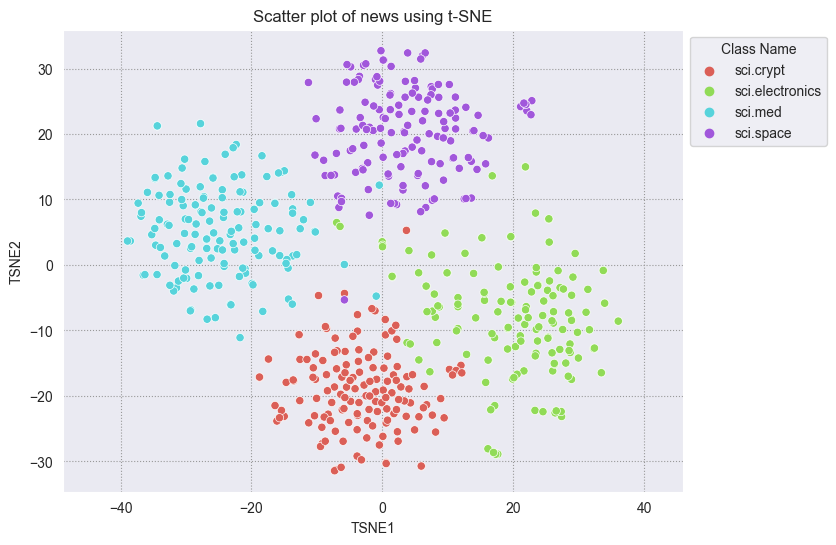

In [242]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Class Name', palette='hls')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using t-SNE');
plt.xlabel('TSNE1');
plt.ylabel('TSNE2');
plt.axis('equal')

In [243]:
# Apply KMeans
kmeans_model = KMeans(n_clusters=4, random_state=1, n_init='auto').fit(X)
labels = kmeans_model.fit_predict(X)

In [244]:
df_tsne['Cluster'] = labels
df_tsne

,TSNE1,TSNE2,Class Name,Cluster
0,-7.003294,-15.865833,sci.crypt,2
1,-3.783758,-22.967747,sci.crypt,2
2,5.573851,-23.191046,sci.crypt,2
3,1.759123,-22.706327,sci.crypt,2
4,-6.133364,-22.127640,sci.crypt,2
...,...,...,...,...
579,7.936444,10.083848,sci.space,1
580,-0.219468,32.716869,sci.space,1
581,4.548163,17.991362,sci.space,1
582,0.435171,22.360491,sci.space,1


/Users/bryanadams/github/LaborFlows/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bryanadams/github/LaborFlows/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/bryanadams/github/LaborFlows/.venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


(-42.67939281463623, 39.77560329437256, -34.64130115509033, 35.92440128326416)

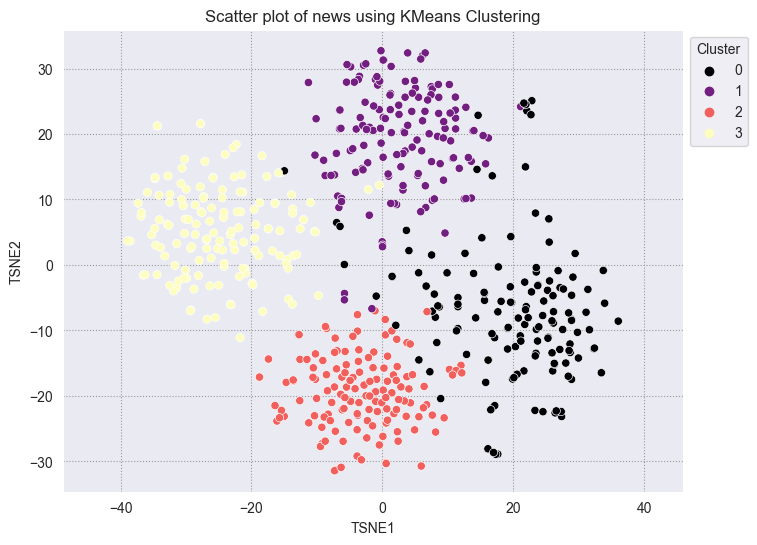

In [255]:
fig, ax = plt.subplots(figsize=(8,6)) # Set figsize
sns.set_style('darkgrid', {"grid.color": ".6", "grid.linestyle": ":"})
sns.scatterplot(data=df_tsne, x='TSNE1', y='TSNE2', hue='Cluster', palette='magma')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title('Scatter plot of news using KMeans Clustering')
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.axis('equal')

In [246]:
def get_majority_cluster_per_group(df_tsne_cluster, class_names):
  class_clusters = dict()
  for c in class_names:
    # Get rows of dataframe that are equal to c
    rows = df_tsne_cluster.loc[df_tsne_cluster['Class Name'] == c]
    # Get majority value in Cluster column of the rows selected
    try:
      cluster = rows.Cluster.mode().values[0]
    except: pass
    # Populate mapping dictionary
    class_clusters[c] = cluster
  return class_clusters

In [248]:
df_tsne['Class Name'].unique()

array(['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space'],
      dtype=object)

In [251]:
classes = df_tsne['Class Name'].unique()
class_clusters = get_majority_cluster_per_group(df_tsne, classes)
class_clusters

{'sci.crypt': 2, 'sci.electronics': 0, 'sci.med': 3, 'sci.space': 1}

In [252]:
# Convert the Cluster column to use the class name
class_by_id = {v: k for k, v in class_clusters.items()}

df_tsne['Predicted'] = df_tsne['Cluster'].map(class_by_id.__getitem__)

# Filter to the correctly matched rows
correct = df_tsne[df_tsne['Class Name'] == df_tsne['Predicted']]

# Summarise, as a percentage
acc = correct['Class Name'].value_counts() / SAMPLE_SIZE
acc

Class Name
sci.med            0.946667
sci.electronics    0.940000
sci.space          0.920000
sci.crypt          0.906667
Name: count, dtype: float64

In [253]:
# Get predicted values by name
df_tsne['Predicted'] = ''
for idx, rows in df_tsne.iterrows():
  cluster = rows['Cluster']
  # Get key from mapping based on cluster value
  key = list(class_clusters.keys())[list(class_clusters.values()).index(cluster)]
  df_tsne.at[idx, 'Predicted'] = key

df_tsne

,TSNE1,TSNE2,Class Name,Cluster,Predicted
0,-7.003294,-15.865833,sci.crypt,2,sci.crypt
1,-3.783758,-22.967747,sci.crypt,2,sci.crypt
2,5.573851,-23.191046,sci.crypt,2,sci.crypt
3,1.759123,-22.706327,sci.crypt,2,sci.crypt
4,-6.133364,-22.127640,sci.crypt,2,sci.crypt
...,...,...,...,...,...
579,7.936444,10.083848,sci.space,1,sci.space
580,-0.219468,32.716869,sci.space,1,sci.space
581,4.548163,17.991362,sci.space,1,sci.space
582,0.435171,22.360491,sci.space,1,sci.space


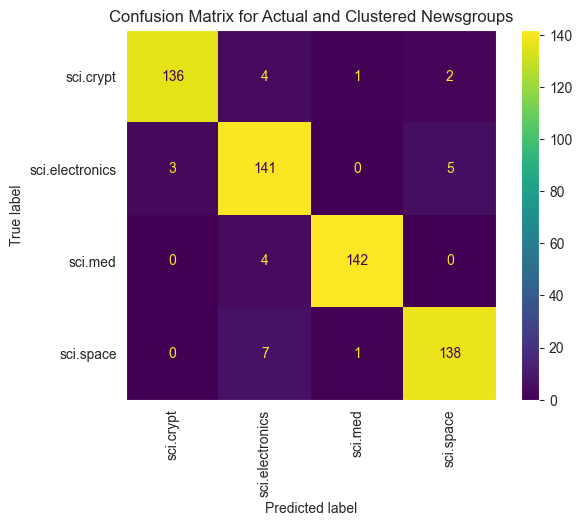

In [254]:
cm = confusion_matrix(df_tsne['Class Name'].to_list(), df_tsne['Predicted'].to_list())
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.title('Confusion Matrix for Actual and Clustered Newsgroups');
plt.grid(False)